In [1]:
testing_company = "SNPS"
winsize = 25

In [2]:
import os
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

path = "./data/"+testing_company+".csv"
temp = pd.read_csv(path)
data = temp["Adj Close"]

In [3]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

adj = {"min":min(data), "max":max(data)}
data = scalar.fit_transform(data.values.reshape(-1,1))

In [4]:
adj

{'min': 47.450001, 'max': 292.089996}

In [5]:
data.shape

(1258, 1)

In [6]:
def split_data(stock, winsize=20):
    data = []
    for idx in range(len(stock) - winsize):
        data.append(stock[idx:idx+winsize])
        
    data = np.array(data)
    
    testsize = int(np.round(0.2*data.shape[0]))
    trainsize = data.shape[0]-testsize
    
    x_train = data[:trainsize, :-1].astype("float32")
    y_train = data[:trainsize, -1].astype("float32")
    
    x_test = data[trainsize:,:-1].astype("float32")
    y_test = data[trainsize:, -1].astype("float32")
    
    return x_train, y_train, x_test, y_test

In [7]:
#HYPERPARAMETERS
epoch = 70
lr = 0.005

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

x_train, y_train, x_test, y_test = split_data(data, winsize)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)


In [9]:
import torch.nn.functional as F
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        out = F.tanh(out)
        out = self.fc2(out)
        out = F.tanh(out)
        out = self.fc3(out)
        return out

In [10]:
input_dim = 1
hidden_dim = 32
output_dim = 1
layers = 2

model = GRU(input_dim, hidden_dim, layers, output_dim)
criterion = nn.L1Loss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)


In [11]:
x_train.shape

torch.Size([986, 24, 1])

In [12]:
history = []
batch = 200

for i in range(epoch):
    x = np.arange(x_train.shape[0])
    np.random.shuffle(x)
    for j in range(0, x_train.shape[0],batch):
        idx = x[j:min(j+batch, x_train.shape[0])]
        pred = model(x_train[idx])
        loss = criterion(pred, y_train[idx])
        history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("Epoch {}({}/{}): loss={}".format(i, j, x_train.shape[0], loss.item()))


Epoch 0(0/986): loss=0.1532425731420517
Epoch 0(200/986): loss=0.1082460880279541
Epoch 0(400/986): loss=0.09385980665683746
Epoch 0(600/986): loss=0.11878834664821625
Epoch 0(800/986): loss=0.11381915211677551
Epoch 1(0/986): loss=0.09232178330421448
Epoch 1(200/986): loss=0.09194761514663696
Epoch 1(400/986): loss=0.09854955971240997
Epoch 1(600/986): loss=0.08680827915668488
Epoch 1(800/986): loss=0.09783782809972763
Epoch 2(0/986): loss=0.0963236540555954
Epoch 2(200/986): loss=0.08363951742649078
Epoch 2(400/986): loss=0.08306321501731873
Epoch 2(600/986): loss=0.08737203478813171
Epoch 2(800/986): loss=0.08767618238925934
Epoch 3(0/986): loss=0.08835473656654358
Epoch 3(200/986): loss=0.08480384945869446
Epoch 3(400/986): loss=0.08057726919651031
Epoch 3(600/986): loss=0.08711723238229752
Epoch 3(800/986): loss=0.08359477669000626
Epoch 4(0/986): loss=0.07693353295326233
Epoch 4(200/986): loss=0.08032345026731491
Epoch 4(400/986): loss=0.07277707010507584
Epoch 4(600/986): loss=0

Epoch 38(0/986): loss=0.0064812274649739265
Epoch 38(200/986): loss=0.005900825373828411
Epoch 38(400/986): loss=0.00835145078599453
Epoch 38(600/986): loss=0.0072455271147191525
Epoch 38(800/986): loss=0.007935109548270702
Epoch 39(0/986): loss=0.005325097590684891
Epoch 39(200/986): loss=0.006533241830766201
Epoch 39(400/986): loss=0.006781566888093948
Epoch 39(600/986): loss=0.005647103767842054
Epoch 39(800/986): loss=0.01016160473227501
Epoch 40(0/986): loss=0.006869068834930658
Epoch 40(200/986): loss=0.006398720666766167
Epoch 40(400/986): loss=0.0066896481439471245
Epoch 40(600/986): loss=0.007478383835405111
Epoch 40(800/986): loss=0.0070915548130869865
Epoch 41(0/986): loss=0.010067428462207317
Epoch 41(200/986): loss=0.006342136766761541
Epoch 41(400/986): loss=0.012148785404860973
Epoch 41(600/986): loss=0.008218297734856606
Epoch 41(800/986): loss=0.014221800491213799
Epoch 42(0/986): loss=0.012639614753425121
Epoch 42(200/986): loss=0.010884679853916168
Epoch 42(400/986):

In [13]:
#for testing
model.eval()
pred = model(x_test)

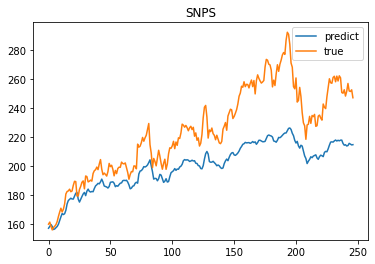

In [14]:
import matplotlib.pyplot as plt

y_pred = pred.detach().numpy()

y_pred = y_pred*(adj["max"] - adj["min"]) + adj["min"]
y_test = y_test*(adj["max"] - adj["min"]) + adj["min"]

plt.title(testing_company)
plt.plot(y_pred, label="predict")
plt.plot(y_test, label="true")
plt.legend()
plt.show()


In [15]:
today = y_pred[-1]
yesterday = y_pred[-2]
change = (today-yesterday)/yesterday

print(testing_company, end=' ')
if change > 0.015:
    print(0)
elif change<-0.015:
    print(2)
else:
    print(1)

SNPS 1


In [16]:
today = y_test[-1]
yesterday = y_test[-2]
change = (today-yesterday)/yesterday

print(testing_company, end=' ')
if change > 0.015:
    print(0)
elif change<-0.015:
    print(2)
else:
    print(1)

SNPS 2
